In [1]:
from IPython.display import clear_output as cls

In [2]:
# data no split
# https://drive.google.com/file/d/1ey1O_1cZEnqP8s4mHjCvT8vpfAOlvP9L/view?usp=sharing

# data with split - train val test
# https://drive.google.com/file/d/14Rjq65k_qzXDje0atzyDl9WziapGaifp/view?usp=sharing

# data with split and converted - train val test
# https://drive.google.com/file/d/10eYtkh6bTWNwH_--xZtU8IxB5cZPVc3O/view?usp=drive_link

!pip install gdown

!rm -r dataset
!gdown "https://drive.google.com/uc?id=10eYtkh6bTWNwH_--xZtU8IxB5cZPVc3O" -O dataset.zip
!unzip dataset.zip -d dataset

cls()

In [3]:
# common
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

# preprocessing
from tensorflow import image as tfi

# architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# output cell
from IPython.display import clear_output as cls

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
train_dir = '/kaggle/working/dataset/data_splitted_convert/train/'
val_dir = '/kaggle/working/dataset/data_splitted_convert/val/'
test_dir = '/kaggle/working/dataset/data_splitted_convert/test/'

In [5]:
# Constants

IMAGE_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 10

LEARNING_RATE = 2e-5

LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = ['accuracy']

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

## Data Loading

In [6]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Show
print(f"Total number of classes in train: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes in train: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


### Drop corrupted data

In [7]:
corrupted = '/kaggle/working/dataset/data_splitted_convert/train/ra/000021.jpg'
os.remove(corrupted)

### Augmentasi

In [8]:
pass

### Input Preprocessing Pipeline

- Rescaling
- Standardization

In [9]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
#     image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

### Load with Tensor Datasets

In [10]:
# del train_ds, val_ds, test_ds
# del train_ds_mapped, val_ds_mapped, test_ds_mapped

# Create a dataset from the data directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
#                                                                labels='inferred', 
#                                                                label_mode='int',
                                                               image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size=BATCH_SIZE
                                                              )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
#                                                              labels='inferred', 
#                                                              label_mode='int',
                                                             image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE
                                                              )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
#                                                               labels='inferred', 
#                                                               label_mode='int',
                                                              image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size=BATCH_SIZE
                                                              )

Found 3759 files belonging to 20 classes.
Found 218 files belonging to 20 classes.
Found 219 files belonging to 20 classes.


### preprocessing

In [11]:
train_ds_mapped = train_ds.map(load_and_preprocess_image)
val_ds_mapped = val_ds.map(load_and_preprocess_image)
test_ds_mapped = test_ds.map(load_and_preprocess_image)

### Data Distribution

In [12]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(val_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(test_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

### Data Visualization

In [13]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 1.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (10, 10).
    """
    
    for images, labels in dataset.take(1):
#     images, labels = next(iter(dataset))
    
        # Create a figure to display the images
        fig = plt.figure(figsize=figsize)

        # Loop over the number of rows and columns
        for i in range(n_rows * n_cols):

            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis])

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, i+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Show the plot
    plt.show()

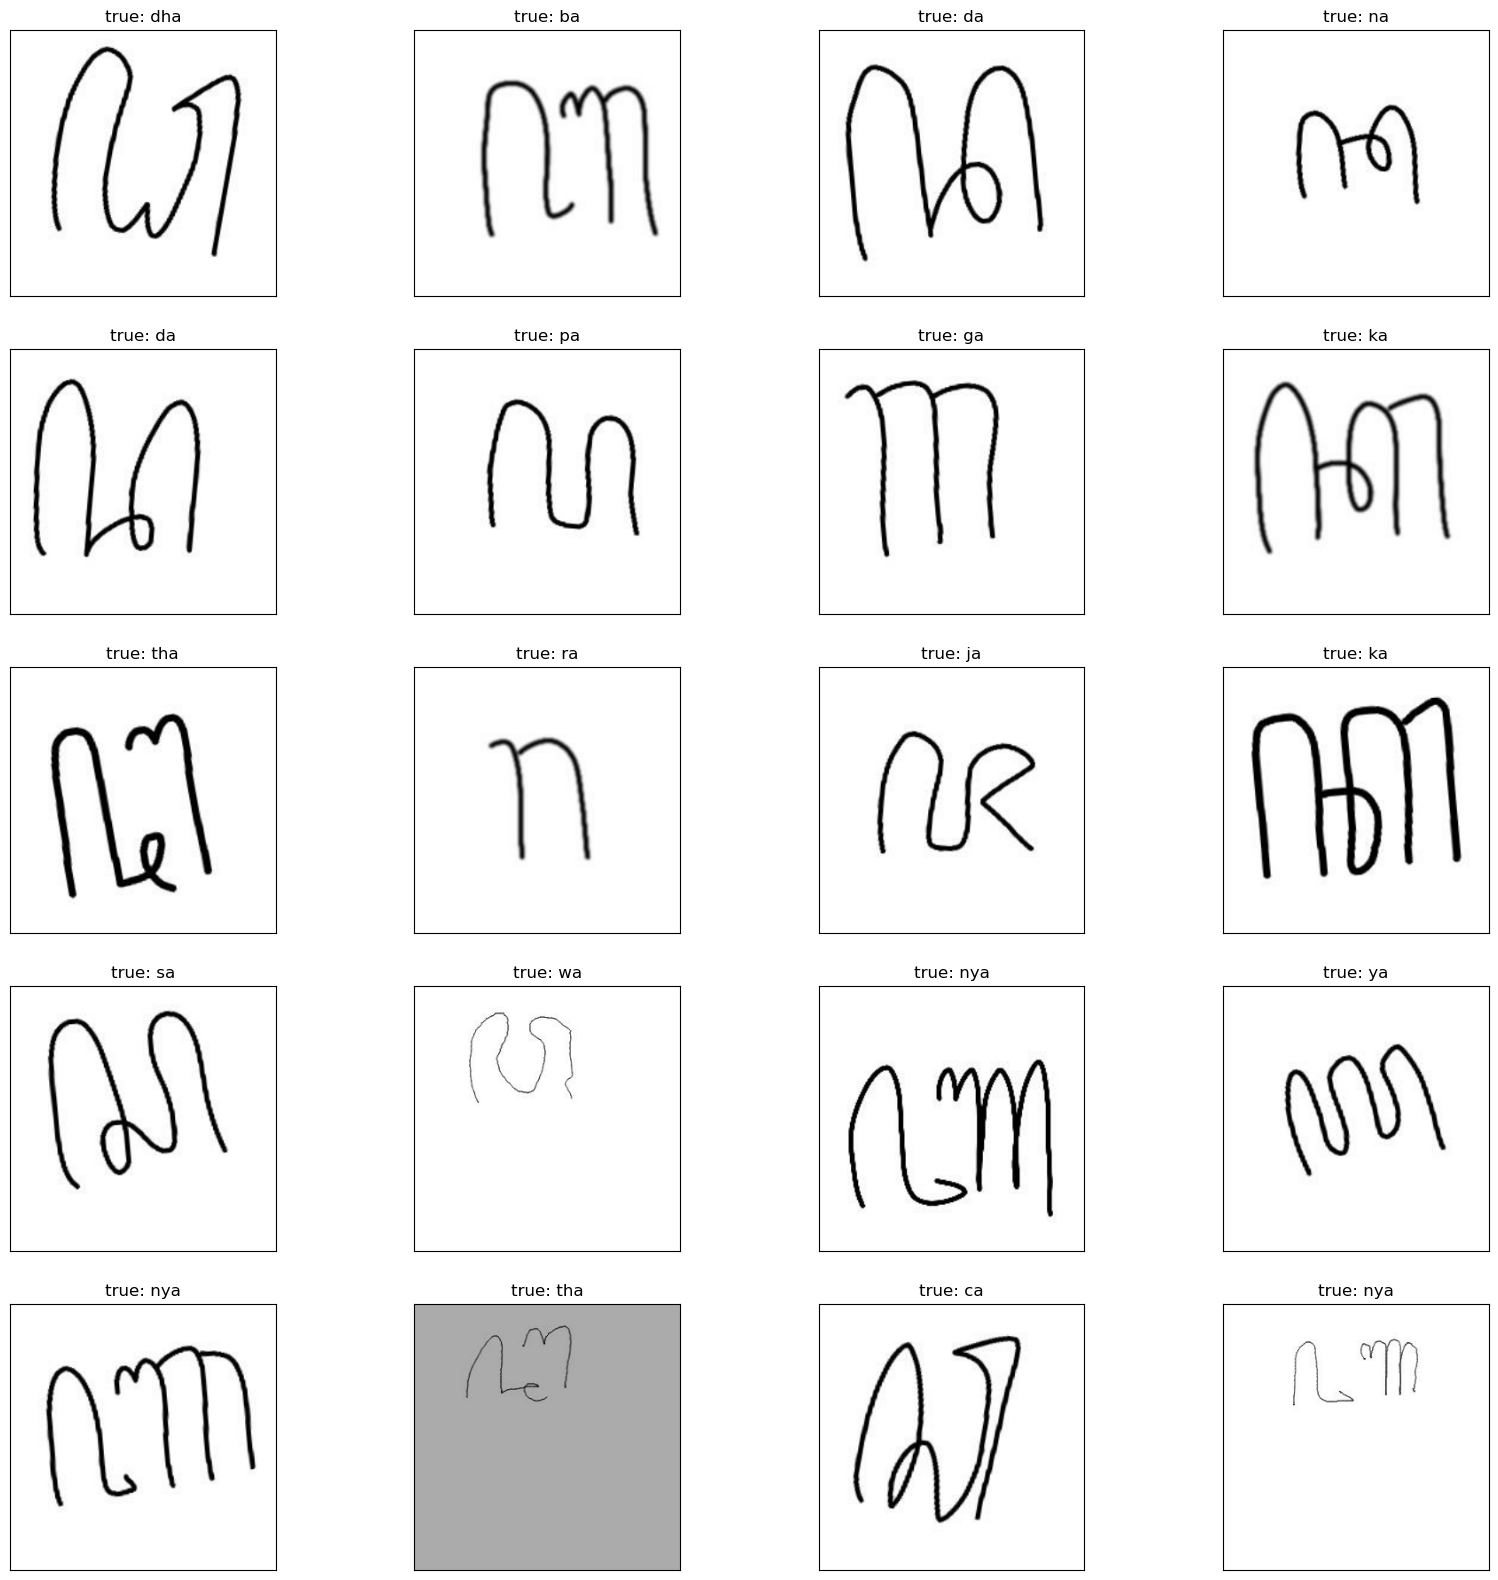

In [14]:
plot_images(train_ds)

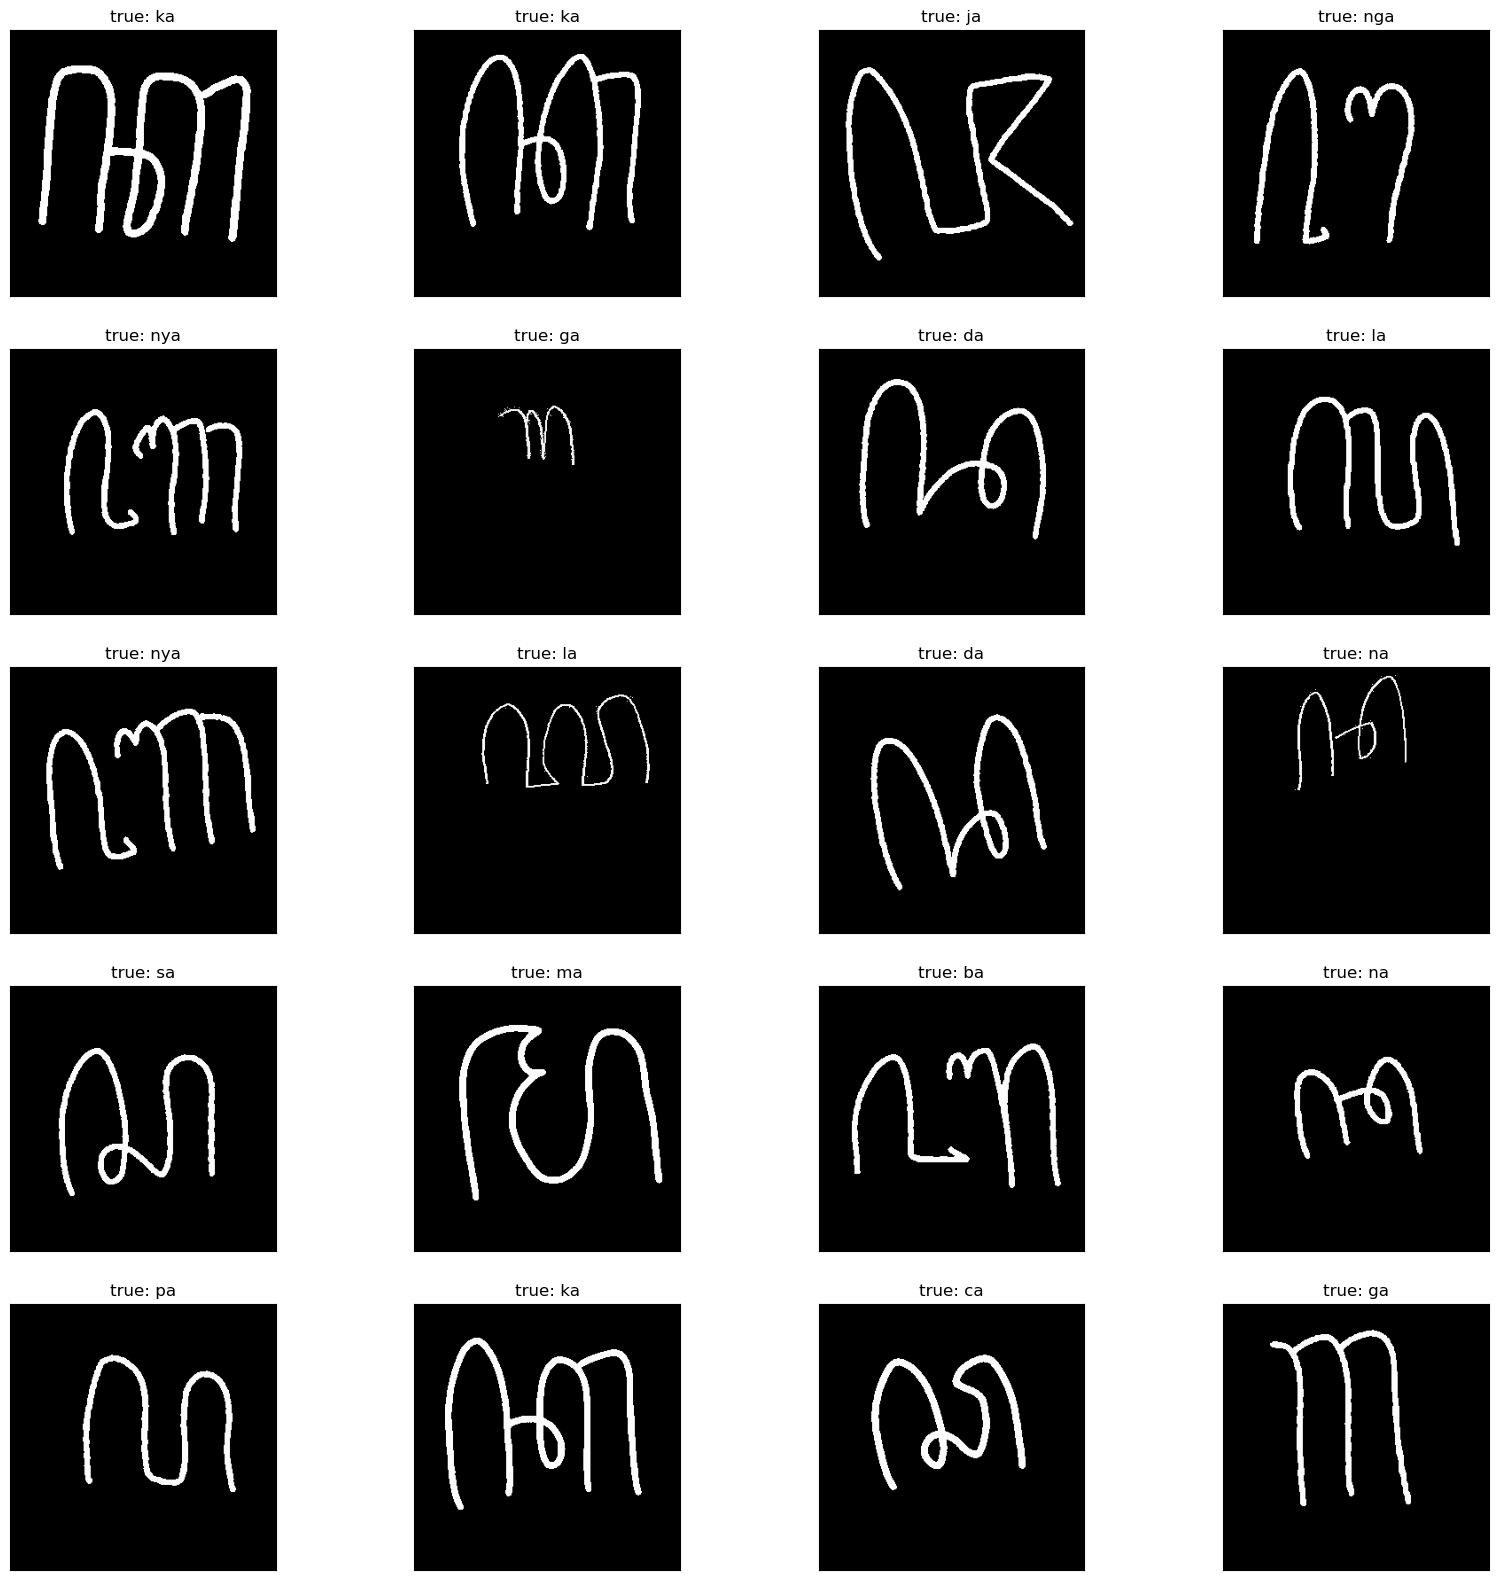

In [15]:
plot_images(train_ds_mapped)

## Train and Fine Tuning

#### Half Freeze

In [19]:
# Xception

xception = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

# xception.trainable = False
xception.trainable = True

In [20]:
num_layers = len(xception.layers) // 2
num_layers

66

In [21]:
for i in range(num_layers):
    xception.layers[i].trainable = False

In [23]:
name = 'aksara_jawa_xception_half_freeze_v1'

xception_transferred = Sequential([
    xception,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name=name)

xception_transferred.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

xception_transferred.summary()

Model: "aksara_jawa_xception_half_freeze_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                40980     
                                                                 
Total params: 20,902,460
Trainable params: 14,899,244
Non-trainable params: 6,003,216
_________________________________________________________________


In [24]:
# Print the trainable status of each layer
for layer in xception_transferred.layers:
    print(f'{layer.name}: {layer.trainable}')

xception: True
global_average_pooling2d_1: True
dropout_1: True
dense_1: True


In [25]:
# plot_model(
#     xception_transferred,
#     to_file='xception_transferred.png',
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
# #     expand_nested=True,
#     dpi=96,
#     show_layer_activations=True
# )

In [26]:
print("\nTraining Xception Model: ")

# steps_per_epoch = len(X_train)
# STEPS_PER_EPOCH = 50

history = xception_transferred.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(f"{name}.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH
)


Training Xception Model: 
Epoch 1/10
118/118 [==============================] - 53s 296ms/step - loss: 2.9011 - accuracy: 0.1277 - val_loss: 2.8325 - val_accuracy: 0.0688
Epoch 2/10
118/118 [==============================] - 34s 283ms/step - loss: 2.0434 - accuracy: 0.4666 - val_loss: 1.5204 - val_accuracy: 0.6330
Epoch 3/10
118/118 [==============================] - 34s 282ms/step - loss: 1.3599 - accuracy: 0.6627 - val_loss: 1.0029 - val_accuracy: 0.7339
Epoch 4/10
118/118 [==============================] - 35s 291ms/step - loss: 1.0312 - accuracy: 0.7539 - val_loss: 0.7004 - val_accuracy: 0.8119
Epoch 5/10
118/118 [==============================] - 34s 284ms/step - loss: 0.7326 - accuracy: 0.8263 - val_loss: 0.5216 - val_accuracy: 0.8440
Epoch 6/10
118/118 [==============================] - 35s 292ms/step - loss: 0.5225 - accuracy: 0.8771 - val_loss: 0.4407 - val_accuracy: 0.8670
Epoch 7/10
118/118 [==============================] - 34s 286ms/step - loss: 0.3799 - accuracy: 0.9149 

## Evaluate

In [28]:
test_loss, test_acc = xception_transferred.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

7/7 [==============================] - 3s 340ms/step - loss: 0.3375 - accuracy: 0.8767
Loss    : 0.3375
Accuracy: 87.67%


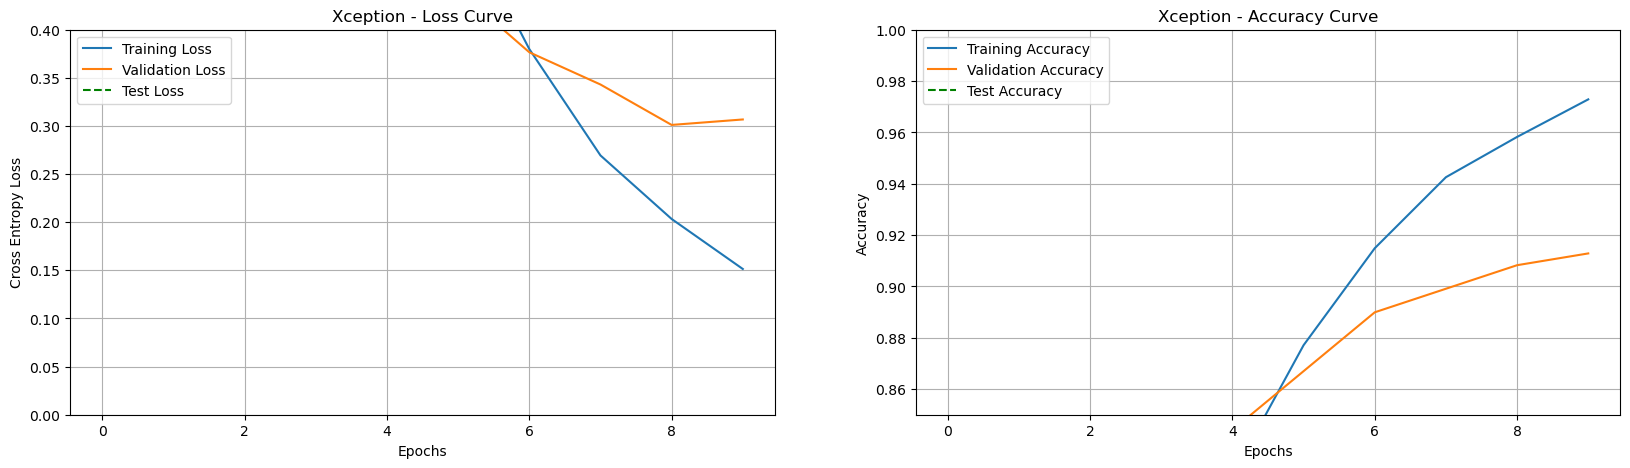

In [30]:
# Collect the history of the training run
history_plot = pd.DataFrame(history.history)

# Create a figure to display the model's performance
plt.figure(figsize=(20, 5))

# Plot the loss curve in the first subplot
plt.subplot(1, 2, 1)
plt.title("Xception - Loss Curve")
plt.plot(history_plot['loss'], label="Training Loss")
plt.plot(history_plot['val_loss'], label="Validation Loss")

# Horizontal line to show the testing performance
plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.ylim([0, 0.4])

# Show the legend and grid
plt.legend()
plt.grid()

# Plot the accuracy curve in the second subplot
plt.subplot(1, 2, 2)
plt.title("Xception - Accuracy Curve")
plt.plot(history_plot['accuracy'], label="Training Accuracy")
plt.plot(history_plot['val_accuracy'], label="Validation Accuracy")

# Horizontal line to show the testing performance
plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.85, 1])

# Show the legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()

## Output Prediction

1/1 [==============================] - 0s 21ms/step


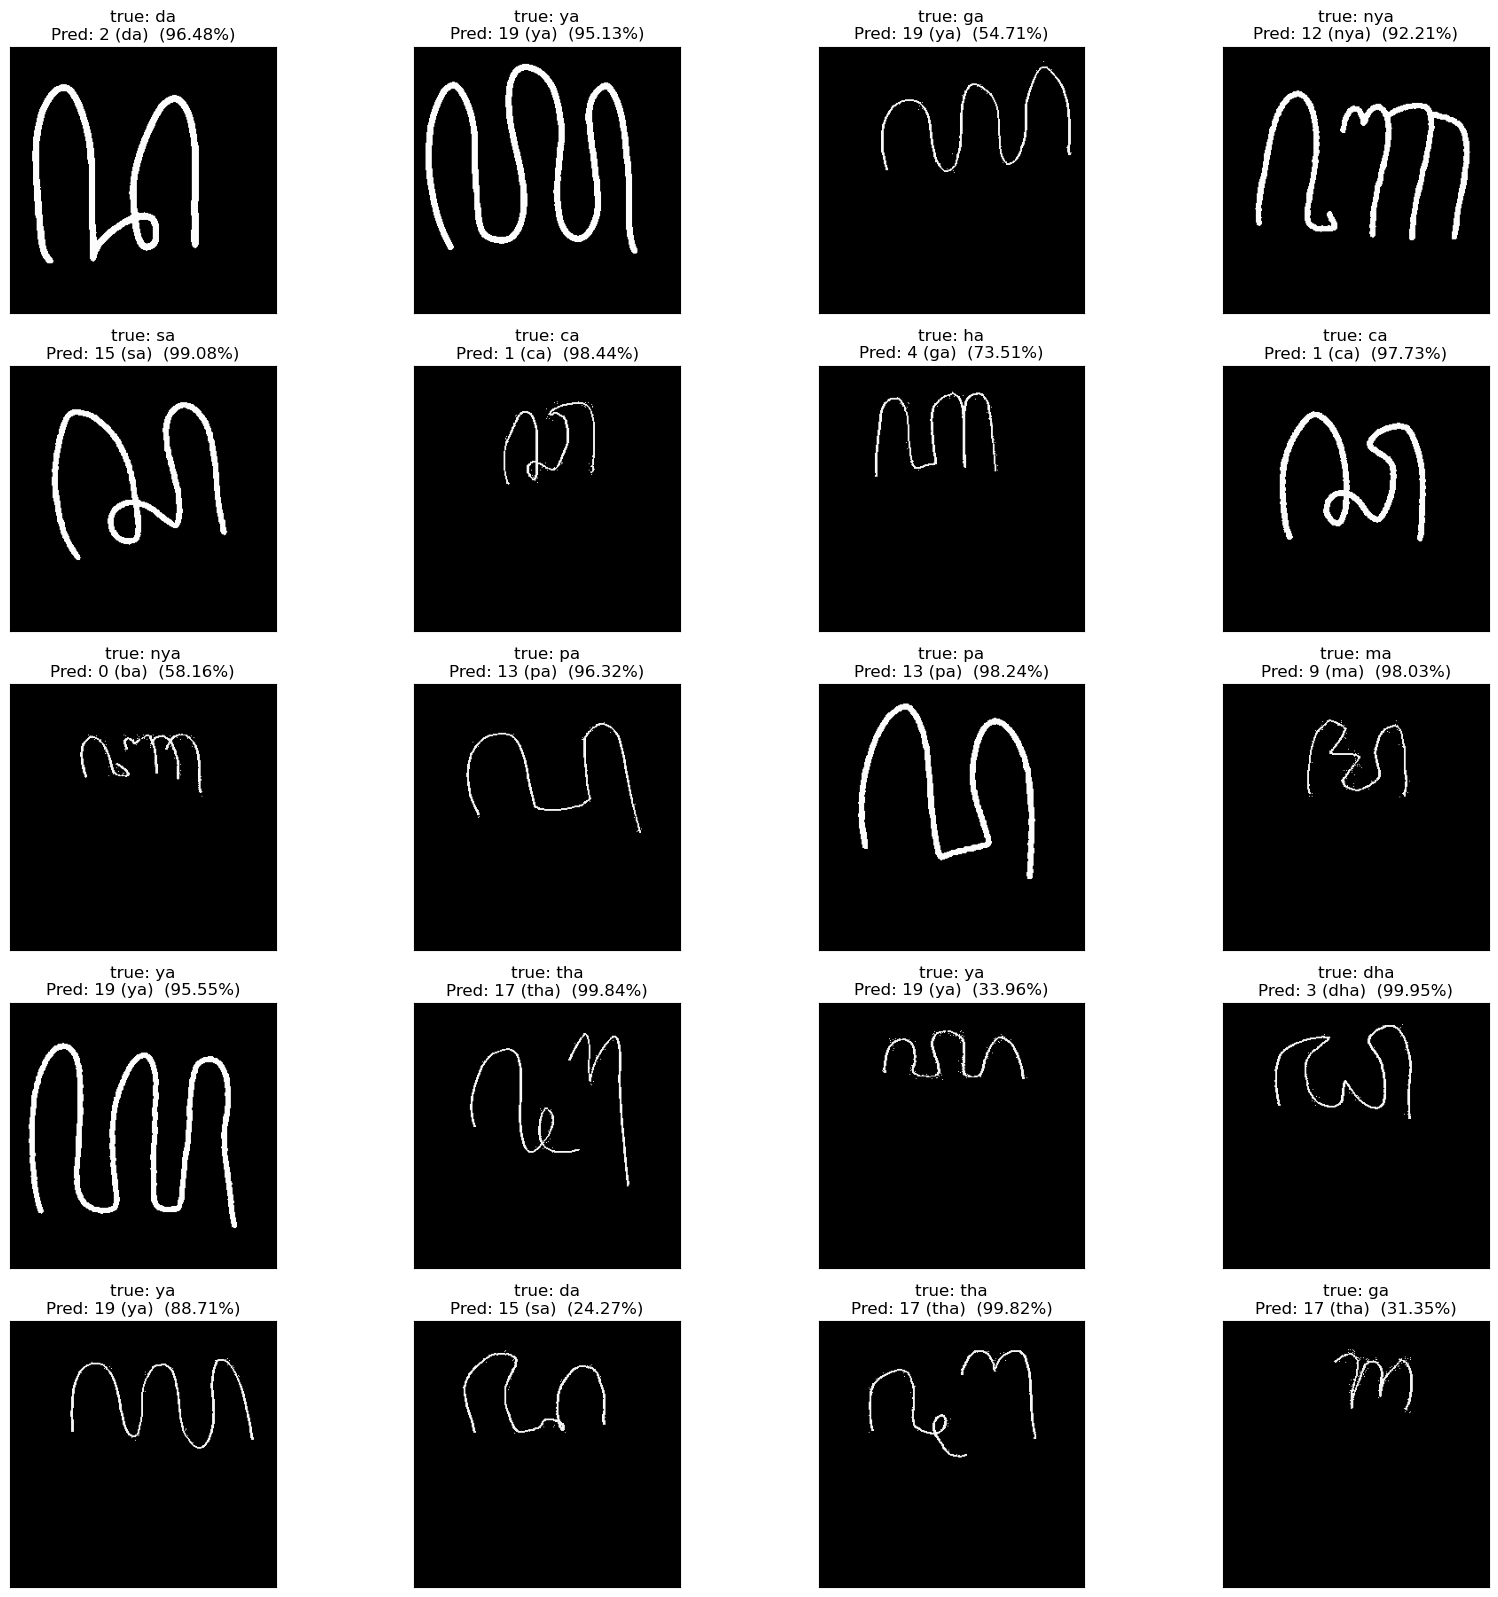

In [32]:
plot_images(test_ds_mapped, model=xception_transferred, n_rows=5)